In [1]:
import networkx as nx
from metro_dataset import MetroDataset, Line
from pytorch_lightning import Trainer
from metro_model import MetroModel
from icecream import ic
import numpy as np
import pandas as pd
import torch
torch.manual_seed(0)

c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cycles

In [2]:
line_1 = Line(nodes=[1,2,3], weight=0.3)
line_2 = Line(nodes=[5,6,7], weight=0.3)
line_3 = Line(nodes=[2,6,8], weight=0.4)

# Dataset

In [3]:
dataset = MetroDataset([line_1, line_2, line_3], init_nb=20)
num_nodes = dataset.cg.num_nodes()

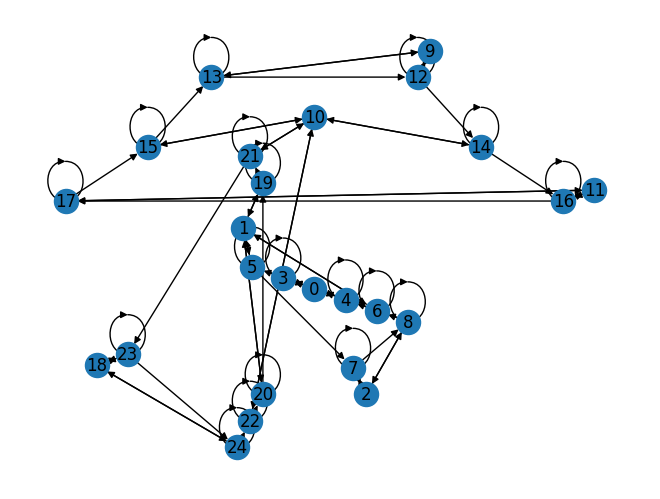

In [4]:
G  = dataset.cg.graph
pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", root=0)
labels = nx.get_node_attributes(G, "station")
nx.draw(G, pos,with_labels=True)

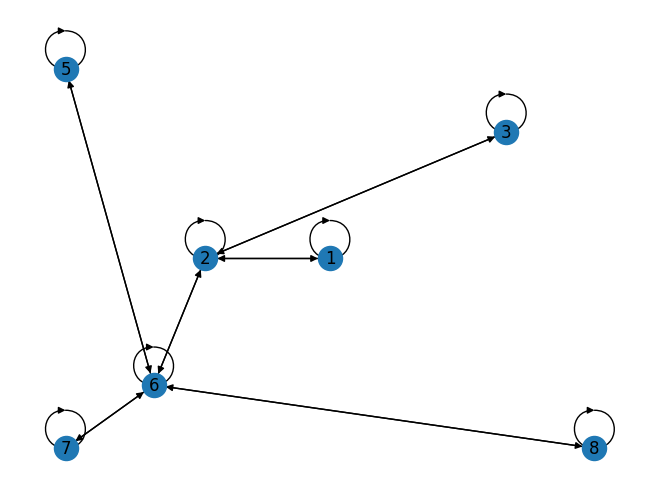

In [5]:
contracted_G = dataset.cg.contract(G)
contracted_pos = nx.nx_agraph.graphviz_layout(contracted_G, prog="twopi", root=0)
contracted_labels = nx.get_node_attributes(contracted_G, "station")
nx.draw(contracted_G, contracted_pos, labels=contracted_labels, with_labels=True)

# Model

In [6]:
A_init = torch.tensor(dataset.cg.adjacency_matrix(), requires_grad=True).float()

In [7]:
model = MetroModel(embedding_size=8, num_nodes=num_nodes, neighbor_nb=1, input_size=1, gsl_mode="matrix") # , 

# Training

In [8]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=8)
trainer = Trainer(max_epochs=50)
trainer.fit(model, train_loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
c:\Users\simon\Projets\CountryTrends\.conda\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Missing logger fol

Epoch 49: 100%|██████████| 248/248 [00:01<00:00, 208.33it/s, loss=2.19e-06, v_num=0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 248/248 [00:01<00:00, 207.29it/s, loss=2.19e-06, v_num=0]


# Evaluation

In [9]:
A = model.graph_matrix_learning().detach().numpy()
# A = model.linear.weight.detach().numpy()
# A = A / A.sum(axis=0)
A = np.array(A)

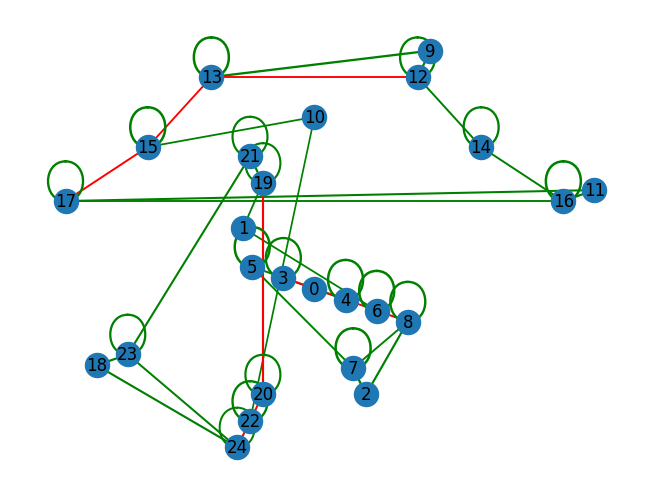

In [10]:
learned_graph = nx.from_numpy_array(A, nx.DiGraph)
labels = {k: v for k, v in enumerate(dataset.dataframes[0].columns)}
learned_graph = nx.relabel_nodes(learned_graph, labels)
weight=nx.get_edge_attributes(learned_graph,'weight')
stations = nx.get_node_attributes(G, "station")
sides = nx.get_node_attributes(G, "side")
correctness = ['green' if e in G.edges() else 'red' for e in learned_graph.edges()]

nx.draw(learned_graph, pos, labels=labels, with_labels=True, width=list(weight.values()), edge_color=correctness)

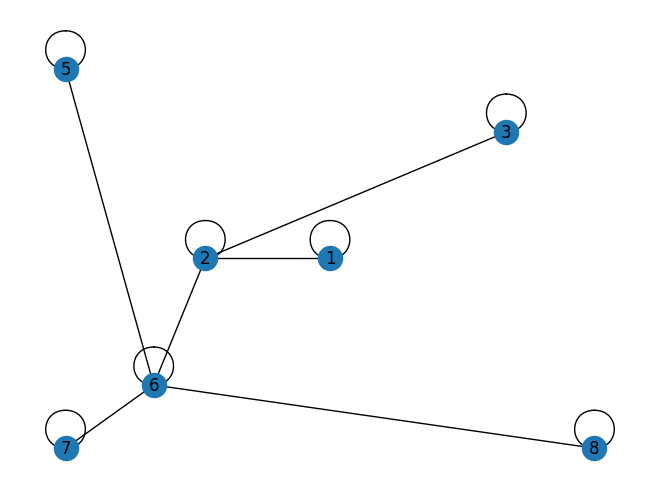

In [11]:
contracted_learned_graph = dataset.cg.contract(learned_graph)
# pos = nx.nx_agraph.graphviz_layout(contracted_G, prog="twopi", root=0)
# labels = nx.get_node_attributes(contracted_G, "station")
nx.draw(contracted_learned_graph, contracted_pos, labels=contracted_labels, with_labels=True)

In [ ]:
# TODO: Essayer avec les embeddings
# TODO: Essayer avec un graph bruité en entrée
# TODO: Essayer avec des data bruitées
# TODO: Essayer avec différents réseaux (de métro)
# TODO: Essayer avec le graphe contracté 